# Libreries

In [2]:
# Load libreries
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import os
import pandas as pd
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model

In [3]:
tf.__version__

'2.3.0'

# Color information

In [4]:
# From color_info.txt -> https://github.com/mcordts/cityscapesScripts/blob/master/cityscapesscripts/helpers/labels.py#L52-L99

# Class names
names = ['unlabeled', 'dynamic', 'ground', 'road', 'sidewalk', 'parking', 'rail track', 'building', 'wall',
         'fence', 'guard rail', 'bridge', 'tunnel', 'pole', 'traffic light', 'traffic sign', 'vegetation', 'terrain', 'sky', 'person', 'rider', 'car', 'truck',
         'bus', 'caravan', 'trailer', 'train', 'motorcycle', 'bicycle', 'license plate']

# Class colors
colors = np.array([(0, 0, 0), (111, 74, 0), (81, 0, 81), (128, 64, 128), (244, 35, 232), (250, 170, 160), (230, 150, 140), (70, 70, 70), 
          (102, 102, 156), (190, 153, 153), (180, 165, 180), (150, 100, 100), (150, 120, 90), (153, 153, 153), (250, 170, 30), (220, 220, 0), (107, 142, 35), 
          (152, 251, 152), (70, 130, 180), (220, 20, 60), (255, 0, 0), ( 0, 0, 142), ( 0, 0, 70), (0, 60, 100), (0, 0, 90), (0, 0, 110), (0, 80, 100), (0, 0, 230), (119, 11, 32), 
          (0, 0, 142)], dtype = np.int32)

# Class info
pd.DataFrame({'Names': names, 'Colour': [col for col in colors]})

,Names,Colour
0,unlabeled,"[0, 0, 0]"
1,dynamic,"[111, 74, 0]"
2,ground,"[81, 0, 81]"
3,road,"[128, 64, 128]"
4,sidewalk,"[244, 35, 232]"
5,parking,"[250, 170, 160]"
6,rail track,"[230, 150, 140]"
7,building,"[70, 70, 70]"
8,wall,"[102, 102, 156]"
9,fence,"[190, 153, 153]"


# Load and preprocess

In [7]:
# Define paths
train_images_folder_path = "./Train_data/Images"
train_mask_folder_path = "./Train_data/Labels"
val_images_folder_path = "./Validation_data/Images"
val_mask_folder_path = "./Validation_data/Labels"
#check_path = '/Data/Checkpoint'

# Get images and masks names
train_images_names = sorted([img for img in os.listdir(train_images_folder_path) if img.endswith('.png')])
train_mask_names = sorted([img for img in os.listdir(train_mask_folder_path) if img.endswith('.png')])
val_images_names = sorted([img for img in os.listdir(val_images_folder_path) if img.endswith('.png')])
val_mask_names = sorted([img for img in os.listdir(val_mask_folder_path) if img.endswith('.png')])

# Count
print(f'Train images: {len(train_images_names)}')
print(f'Train labels: {len(train_mask_names)}')
print(f'Validation images: {len(val_images_names)}')
print(f'Validation labels: {len(val_mask_names)}')

Train images: 2975
Train labels: 2975
Validation images: 500
Validation labels: 500


In [8]:
# Define image shape
img_width, img_height = 256, 256

# One hot function with the colors
def one_hot_mask(y):
  one_hot_map = []
  for color in colors:
    class_map = tf.reduce_all(tf.equal(y, color), axis = -1)
    one_hot_map.append(class_map)
  mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
  return mask

# Load image, resize and normalize
def load_image_train(file, height, width):
  image = tf.io.read_file(train_images_folder_path + '/' + file)
  image = tf.cast(tf.image.decode_png(image, channels = 3), tf.float32)
  image = tf.image.resize(image, (height, width))
  image = tf.cast(image, tf.float32)/255.0
  return image

# Load mask, resize and one_hot
def load_mask_train(file, height, width, one_hot = True):
  image = tf.io.read_file(train_mask_folder_path + '/' + file)
  image = tf.cast(tf.image.decode_png(image, channels = 3), tf.int32)
  image = tf.image.resize(image, (height, width), method = tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  if one_hot:
    image = one_hot_mask(image)
  return image

# Load image and mask together
def load(image_name, mask_name):
  image = load_image_train(image_name, img_height, img_width)
  mask = load_mask_train(mask_name, img_height, img_width)
  return image, mask

In [9]:
# Check mask shape after one hot encoding
load_mask_train(train_mask_names[0], 256, 256).shape

TensorShape([256, 256, 30])

In [10]:
# Create tensorflow dataset
dataset = tf.data.Dataset.from_tensor_slices((train_images_names[:50], train_mask_names[:50]))
dataset = dataset.map(load, num_parallel_calls = tf.data.experimental.AUTOTUNE)
dataset = dataset.batch(32)
dataset

<BatchDataset shapes: ((None, 256, 256, 3), (None, 256, 256, 30)), types: (tf.float32, tf.int32)>

# Visualization

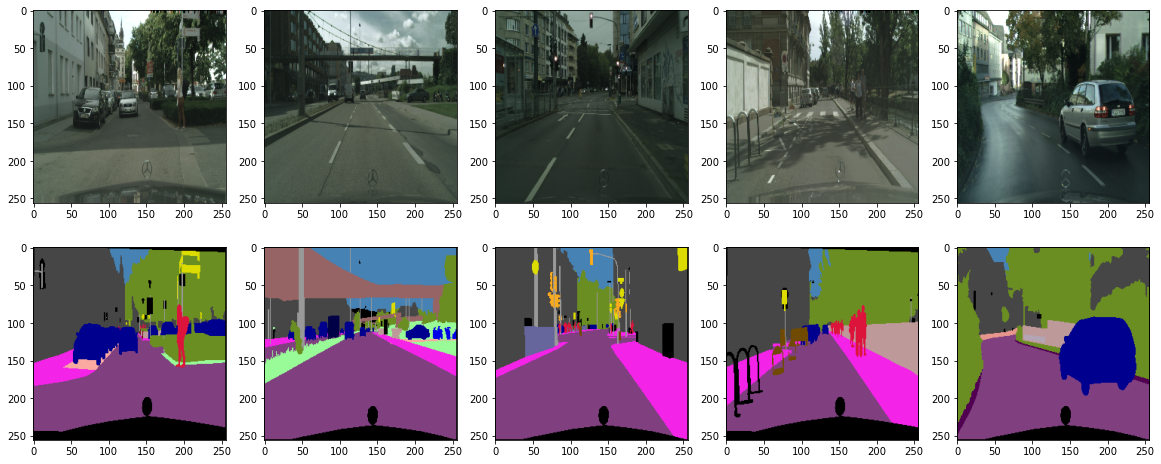

In [11]:
# Plot 5 random images
idx = np.random.choice(len(train_images_names), 5)
plt.figure(figsize = (20, 8))
for i in range(5):
  plt.subplot(2, 5, i + 1)
  plt.imshow(load_image_train(train_images_names[idx[i]], img_height, img_width))
  plt.subplot(2, 5, i + 6)
  plt.imshow(load_mask_train(train_mask_names[idx[i]], img_height, img_width, one_hot = False))
plt.show()

# Check one hot

Check to be sure that the one hot is working correctly.

In [12]:
prueba = load_mask_train(train_mask_names[0], 2, 2, one_hot = False)
prueba

<tf.Tensor: shape=(2, 2, 3), dtype=int32, numpy=
array([[[107, 142,  35],
        [107, 142,  35]],

       [[128,  64, 128],
        [128,  64, 128]]])>

In [13]:
one_hot_map = []
for color in colors[:5]:
  class_map = tf.reduce_all(tf.equal(prueba, color), axis = -1)
  one_hot_map.append(class_map)

In [14]:
one_hot_map

[<tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [ True,  True]])>,
 <tf.Tensor: shape=(2, 2), dtype=bool, numpy=
 array([[False, False],
        [False, False]])>]

In [15]:
mask = tf.cast(tf.stack(one_hot_map, axis = -1), tf.int32)
mask

<tf.Tensor: shape=(2, 2, 5), dtype=int32, numpy=
array([[[0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0]],

       [[0, 0, 0, 1, 0],
        [0, 0, 0, 1, 0]]])>

# NN without GDN

U-Net model without generalized division normalization.

In [16]:
def conv_block(inputs, filters, pool = True):
    x = Conv2D(filters, 3, padding = "same")(inputs)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv2D(filters, 3, padding = "same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    if pool == True:
        p = MaxPool2D((2, 2))(x)
        return x, p
    else:
        return x


def build_unet(shape, num_classes):
    inputs = Input(shape)

    #Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    x2, p2 = conv_block(p1, 32, pool = True)
    x3, p3 = conv_block(p2, 48, pool = True)
    x4, p4 = conv_block(p3, 64, pool = True)

    #Bridge
    b1 = conv_block(p4, 128, pool = False)

    #Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    #Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

In [17]:
# Build the model
model1 = build_unet((256, 256, 3), 30)
model1.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [18]:
# Train the model for a small number of epochs
lr = 1e-4
epochs = 10

model1.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr))

model1.fit(dataset, epochs = epochs)

Epoch 1/10
2/2 [==============================] - 7s 4s/step - loss: 3.8132
Epoch 2/10
2/2 [==============================] - 7s 4s/step - loss: 3.6879
Epoch 3/10
2/2 [==============================] - 7s 4s/step - loss: 3.6212
Epoch 4/10
2/2 [==============================] - 8s 4s/step - loss: 3.5683
Epoch 5/10
2/2 [==============================] - 8s 4s/step - loss: 3.5205
Epoch 6/10
2/2 [==============================] - 8s 4s/step - loss: 3.4743
Epoch 7/10
2/2 [==============================] - 8s 4s/step - loss: 3.4298
Epoch 8/10
2/2 [==============================] - 8s 4s/step - loss: 3.3920
Epoch 9/10
2/2 [==============================] - 8s 4s/step - loss: 3.3608
Epoch 10/10
2/2 [==============================] - 8s 4s/step - loss: 3.3323


# NN with GDN

U-Net model with generalized division normalization.

In [21]:
# !pip install tensorflow-compression

In [20]:
from tensorflow_compression import GDN

ModuleNotFoundError: No module named 'tensorflow_compression'

In [ ]:
def build_unet_gdn(shape, num_classes):
    inputs = Input(shape)

    #Encoder
    x1, p1 = conv_block(inputs, 16, pool = True)
    p1_1 = GDN()(p1)
    x2, p2 = conv_block(p1_1, 32, pool = True)
    p2_2 = GDN()(p2)
    x3, p3 = conv_block(p2_2, 48, pool = True)
    p3_3 = GDN()(p3)
    x4, p4 = conv_block(p3_3, 64, pool = True)

    #Bridge
    b1 = conv_block(p4, 128, pool = False)

    #Decoder
    u1 = UpSampling2D((2, 2), interpolation = "bilinear")(b1)
    c1 = Concatenate()([u1, x4])
    x5 = conv_block(c1, 64, pool = False)

    u2 = UpSampling2D((2, 2), interpolation = "bilinear")(x5)
    c2 = Concatenate()([u2, x3])
    x6 = conv_block(c2, 48, pool = False)

    u3 = UpSampling2D((2, 2), interpolation = "bilinear")(x6)
    c3 = Concatenate()([u3, x2])
    x7 = conv_block(c3, 32, pool = False)

    u4 = UpSampling2D((2, 2), interpolation = "bilinear")(x7)
    c4 = Concatenate()([u4, x1])
    x8 = conv_block(c4, 16, pool = False)

    #Output
    output = Conv2D(num_classes, 1, padding = 'same', activation = 'softmax')(x8)

    return Model(inputs, output)

# Build the model
model_2 = build_unet_gdn((256, 256, 3), 30)
model_2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 256, 256, 16) 448         input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 256, 256, 16) 64          conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 256, 256, 16) 0           batch_normalization_18[0][0]     
____________________________________________________________________________________________

In [ ]:
# Train the model for a small number of epochs
lr = 1e-4
epochs = 10

model_2.compile(loss = 'categorical_crossentropy', optimizer = tf.keras.optimizers.Adam(learning_rate = lr))

model_2.fit(dataset, epochs = epochs)

Epoch 1/10
2/2 [==============================] - 10s 2s/step - loss: 3.9108
Epoch 2/10
2/2 [==============================] - 7s 2s/step - loss: 3.8160
Epoch 3/10
2/2 [==============================] - 7s 2s/step - loss: 3.7501
Epoch 4/10
2/2 [==============================] - 7s 2s/step - loss: 3.6983
Epoch 5/10
2/2 [==============================] - 7s 2s/step - loss: 3.6558
Epoch 6/10
2/2 [==============================] - 7s 2s/step - loss: 3.6173
Epoch 7/10
2/2 [==============================] - 7s 2s/step - loss: 3.5801
Epoch 8/10
2/2 [==============================] - 7s 2s/step - loss: 3.5441
Epoch 9/10
2/2 [==============================] - 7s 2s/step - loss: 3.5096
Epoch 10/10
2/2 [==============================] - 7s 2s/step - loss: 3.4769
